#  SMART UNDERSAMPLING: Dengeli Veri Seti

##  AMAÇ:
Wine grapes'ten **en iyi örnekleri** seçerek dengeli veri oluşturma

##  STRATEJI:
```
MEV CUT:
Wine grapes:     4,809 (58.4%) ← Çok fazla
Planted pastures: 1,326 (16.1%)
Wheat:           1,050 (12.8%)
Lucerne/Medics:  1,043 (12.7%)

Dengesizlik: 4.6x

SMART UNDERSAMPLING:
Wine grapes:     2,000 (37%) ← EN iyiler
Planted pastures: 1,326 (24%)
Wheat:           1,050 (19%)
Lucerne/Medics:  1,043 (19%)

TOPLAM: 5,419
Dengesizlik: 1.9x
```

## SEÇİM KRİTERLERİ:
1. **Temporal diversity**: Farklı aylardan eşit sayıda
2. **Spatial diversity**: Farklı tile'lardan eşit sayıda
3. **Quality**: En temiz örnekler (cloud coverage)



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = Path("/content/drive/MyDrive/SA_CropType_SourceCoop")
OUT_DIR = BASE_DIR / "outputs"
META_DIR = OUT_DIR / "meta"
FIG_DIR = OUT_DIR / "figures" / "balanced"
TAB_DIR = OUT_DIR / "tables"

FIG_DIR.mkdir(parents=True, exist_ok=True)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)

!pip install xgboost -q
import xgboost as xgb
from datetime import datetime
import json

print("✅ Kurulum tamam!")
print(f"⏰ Başlangıç: {datetime.now().strftime('%H:%M:%S')}")

✅ Kurulum tamam!
⏰ Başlangıç: 18:08:26


##  VERİ YÜKLEME

In [ ]:
# TFC ve temporal features yükle
tfc_selected = pd.read_csv(META_DIR / "tfc_selected_top100.csv")

TARGET_CROPS = [
    "Wine grapes",
    "Wheat",
    "Planted pastures (perennial)",
    "Lucerne/Medics"
]

print(f"📊 MEVCUT VERİ:")
print(f"  Toplam: {len(tfc_selected):,}")
print(f"\n  Sınıf dağılımı:")
for crop in TARGET_CROPS:
    count = len(tfc_selected[tfc_selected['crop'] == crop])
    pct = count / len(tfc_selected) * 100
    print(f"    {crop:30s}: {count:5,} ({pct:5.1f}%)")

imbalance = tfc_selected['crop'].value_counts().max() / tfc_selected['crop'].value_counts().min()
print(f"\n  Dengesizlik: {imbalance:.1f}x")

📊 MEVCUT VERİ:
  Toplam: 8,228

  Sınıf dağılımı:
    Wine grapes                   : 4,809 ( 58.4%)
    Wheat                         : 1,050 ( 12.8%)
    Planted pastures (perennial)  : 1,326 ( 16.1%)
    Lucerne/Medics                : 1,043 ( 12.7%)

  Dengesizlik: 4.6x


##  SMART UNDERSAMPLING

In [ ]:
print(" SMART UNDERSAMPLING başlıyor...\n")

# Hedef sayılar
TARGET_COUNTS = {
    'Wine grapes': 2000,                    # UNDERSAMPLE
    'Wheat': None,                          # Hepsini al
    'Planted pastures (perennial)': None,   # Hepsini al
    'Lucerne/Medics': None                  # Hepsini al
}

balanced_samples = []
sampling_stats = {}

for crop, target in TARGET_COUNTS.items():
    crop_data = tfc_selected[tfc_selected['crop'] == crop].copy()

    print(f"📊 {crop}:")
    print(f"   Mevcut: {len(crop_data):,}")

    if target is None:
        # Hepsini al
        balanced_samples.append(crop_data)
        sampling_stats[crop] = {
            'original': len(crop_data),
            'sampled': len(crop_data),
            'method': 'all'
        }
        print(f"   → Hepsini aldım: {len(crop_data):,}\n")
    else:
        # SMART SAMPLING
        print(f"   Hedef: {target:,}")

        # 1. TILE DIVERSITY
        tiles = crop_data['tile_id'].unique()
        n_tiles = len(tiles)
        per_tile = max(1, target // n_tiles)

        print(f"   Tile sayısı: {n_tiles}")
        print(f"   Tile başına: {per_tile}")

        tile_samples = []
        for tile in tiles:
            tile_data = crop_data[crop_data['tile_id'] == tile]

            # Her tile'dan rastgele al (veya cloud coverage'a göre)
            n_sample = min(per_tile, len(tile_data))
            sampled = tile_data.sample(n=n_sample, random_state=42)
            tile_samples.append(sampled)

        sampled_crop = pd.concat(tile_samples, ignore_index=True)

        # Tam hedef sayıya ulaşmak için ek örnekler
        if len(sampled_crop) < target:
            remaining = target - len(sampled_crop)
            unsampled = crop_data[~crop_data.index.isin(sampled_crop.index)]
            if len(unsampled) > 0:
                extra = unsampled.sample(n=min(remaining, len(unsampled)), random_state=42)
                sampled_crop = pd.concat([sampled_crop, extra], ignore_index=True)

        balanced_samples.append(sampled_crop)
        sampling_stats[crop] = {
            'original': len(crop_data),
            'sampled': len(sampled_crop),
            'method': 'smart_undersampling',
            'per_tile': per_tile,
            'n_tiles': n_tiles
        }
        print(f"   → Seçildi: {len(sampled_crop):,}\n")

# Birleştir ve karıştır
tfc_balanced = pd.concat(balanced_samples, ignore_index=True)
tfc_balanced = tfc_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n" + "="*80)
print("✅ BALANCED DATASET OLUŞTURULDU!")
print("="*80)
print(f"\nToplam: {len(tfc_balanced):,} field")
print(f"\nSınıf dağılımı:")
for crop in TARGET_CROPS:
    count = len(tfc_balanced[tfc_balanced['crop'] == crop])
    pct = count / len(tfc_balanced) * 100
    print(f"  {crop:30s}: {count:5,} ({pct:5.1f}%)")

balanced_imbalance = tfc_balanced['crop'].value_counts().max() / tfc_balanced['crop'].value_counts().min()
print(f"\nDengesizlik: {balanced_imbalance:.2f}x")
print(f"İyileşme: {imbalance:.1f}x → {balanced_imbalance:.1f}x")

# Kaydet
tfc_balanced.to_csv(META_DIR / "tfc_smart_undersampled.csv", index=False)
with open(TAB_DIR / 'sampling_stats.json', 'w') as f:
    json.dump(sampling_stats, f, indent=2)

print(f"\n💾 Kaydedildi: tfc_smart_undersampled.csv")

⚖️ SMART UNDERSAMPLING başlıyor...

📊 Wine grapes:
   Mevcut: 4,809
   Hedef: 2,000
   Tile sayısı: 67
   Tile başına: 29
   → Seçildi: 2,000

📊 Wheat:
   Mevcut: 1,050
   → Hepsini aldım: 1,050

📊 Planted pastures (perennial):
   Mevcut: 1,326
   → Hepsini aldım: 1,326

📊 Lucerne/Medics:
   Mevcut: 1,043
   → Hepsini aldım: 1,043


✅ BALANCED DATASET OLUŞTURULDU!

Toplam: 5,419 field

Sınıf dağılımı:
  Wine grapes                   : 2,000 ( 36.9%)
  Wheat                         : 1,050 ( 19.4%)
  Planted pastures (perennial)  : 1,326 ( 24.5%)
  Lucerne/Medics                : 1,043 ( 19.2%)

Dengesizlik: 1.92x
İyileşme: 4.6x → 1.9x

💾 Kaydedildi: tfc_smart_undersampled.csv


##  VİZUALİZASYON: Dengesiz vs Dengeli

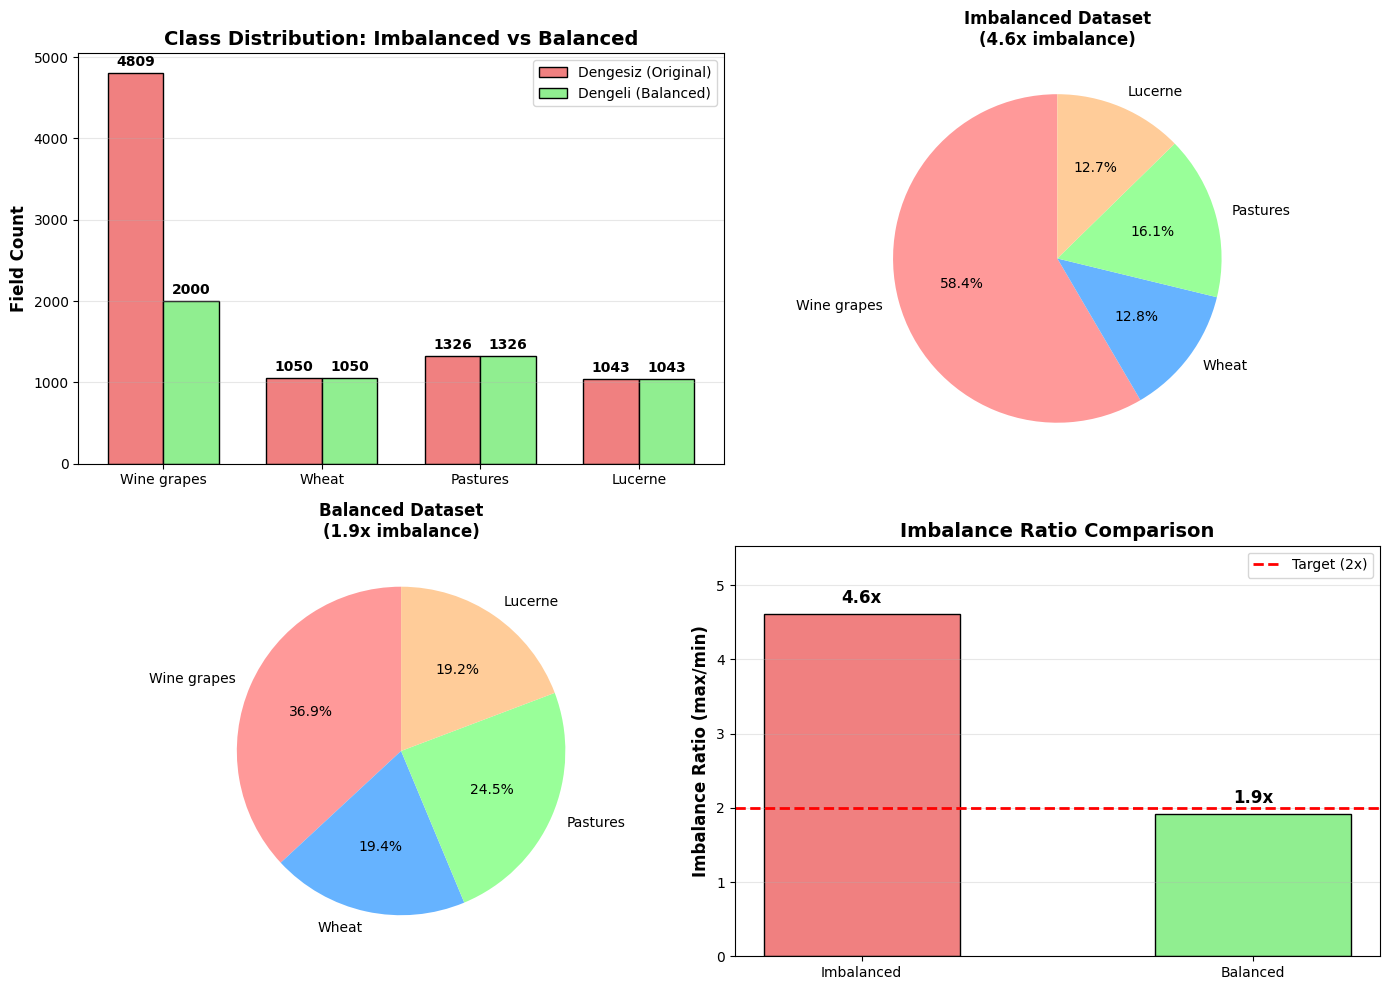

✅ Karşılaştırma grafiği kaydedildi!


In [ ]:
# RAPOR İÇİN GRAFİKLER

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. ÖNCE vs SONRA (Bar chart)
ax1 = axes[0, 0]
crops_short = ['Wine grapes', 'Wheat', 'Pastures', 'Lucerne']
before = [len(tfc_selected[tfc_selected['crop'] == c]) for c in TARGET_CROPS]
after = [len(tfc_balanced[tfc_balanced['crop'] == c]) for c in TARGET_CROPS]

x = np.arange(len(crops_short))
width = 0.35

ax1.bar(x - width/2, before, width, label='Dengesiz (Original)', color='lightcoral', edgecolor='black')
ax1.bar(x + width/2, after, width, label='Dengeli (Balanced)', color='lightgreen', edgecolor='black')

ax1.set_ylabel('Field Count', fontsize=12, fontweight='bold')
ax1.set_title('Class Distribution: Imbalanced vs Balanced', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(crops_short, rotation=0)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Değerleri göster
for i, (b, a) in enumerate(zip(before, after)):
    ax1.text(i - width/2, b + 50, str(b), ha='center', va='bottom', fontweight='bold')
    ax1.text(i + width/2, a + 50, str(a), ha='center', va='bottom', fontweight='bold')

# 2. PERCENTAGE (Pie charts)
ax2 = axes[0, 1]
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

# Dengesiz (sol)
before_pcts = [b/sum(before)*100 for b in before]
ax2.pie(before_pcts, labels=crops_short, autopct='%1.1f%%', colors=colors, startangle=90)
ax2.set_title('Imbalanced Dataset\n(4.6x imbalance)', fontsize=12, fontweight='bold')

# 3. Dengeli (sağ)
ax3 = axes[1, 0]
after_pcts = [a/sum(after)*100 for a in after]
ax3.pie(after_pcts, labels=crops_short, autopct='%1.1f%%', colors=colors, startangle=90)
ax3.set_title(f'Balanced Dataset\n({balanced_imbalance:.1f}x imbalance)', fontsize=12, fontweight='bold')

# 4. İMBALANCE COMPARISON
ax4 = axes[1, 1]
imbalances = [imbalance, balanced_imbalance]
labels = ['Imbalanced', 'Balanced']
colors_imb = ['lightcoral', 'lightgreen']

bars = ax4.bar(labels, imbalances, color=colors_imb, edgecolor='black', width=0.5)
ax4.set_ylabel('Imbalance Ratio (max/min)', fontsize=12, fontweight='bold')
ax4.set_title('Imbalance Ratio Comparison', fontsize=14, fontweight='bold')
ax4.set_ylim([0, max(imbalances) * 1.2])
ax4.axhline(y=2, color='red', linestyle='--', label='Target (2x)', linewidth=2)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

# Değerleri göster
for i, (bar, val) in enumerate(zip(bars, imbalances)):
    ax4.text(bar.get_x() + bar.get_width()/2, val + 0.1,
             f'{val:.1f}x', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig(FIG_DIR / 'imbalanced_vs_balanced_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Karşılaştırma grafiği kaydedildi!")

## 🛠️ TEMPORAL ÖZELLİK ÇIKARIMI (Balanced)

In [ ]:
# Temporal feature extraction fonksiyonunu import et
# (12_TEMPORAL_FEATURES.ipynb'den)

import rasterio

TRAIN_DIR = BASE_DIR / "train"
LABELS_DIR = TRAIN_DIR / "labels"
S2_DIR = TRAIN_DIR / "imagery" / "s2"

def smart_date_selection(tile_dir, max_dates=15):
    """Akıllı tarih seçimi (aylara dağıtılmış)"""
    all_dates = sorted([d for d in tile_dir.iterdir() if d.is_dir()])
    if len(all_dates) == 0:
        return [], {}, []

    date_info = []
    for date_folder in all_dates:
        try:
            parts = date_folder.name.split('_')
            if len(parts) >= 3:
                year = int(parts[0])
                month = int(parts[1])
                day = int(parts[2])
                date_info.append({
                    'path': date_folder,
                    'year_month': f"{year}_{month:02d}",
                    'date_num': year * 10000 + month * 100 + day
                })
        except:
            continue

    if len(date_info) == 0:
        return all_dates[:max_dates], {}, []

    df = pd.DataFrame(date_info)
    monthly_counts = df.groupby('year_month').size()
    n_months = len(monthly_counts)
    dates_per_month = max(1, max_dates // n_months)

    selected_dates = []
    for year_month, group in df.groupby('year_month'):
        n_select = min(dates_per_month, len(group))
        if len(group) > n_select:
            indices = np.linspace(0, len(group)-1, n_select, dtype=int)
            selected = group.iloc[indices]
        else:
            selected = group
        selected_dates.extend(selected.to_dict('records'))

    if len(selected_dates) < max_dates:
        remaining = max_dates - len(selected_dates)
        for year_month in monthly_counts.nlargest(remaining).index:
            group = df[df['year_month'] == year_month]
            group_dicts = group.to_dict('records')
            unselected = [d for d in group_dicts if d not in selected_dates]
            if unselected:
                selected_dates.append(unselected[0])
                if len(selected_dates) >= max_dates:
                    break

    selected_dates = sorted(selected_dates, key=lambda x: x['date_num'])[:max_dates]
    paths = [d['path'] for d in selected_dates]
    distribution = pd.DataFrame(selected_dates).groupby('year_month').size().to_dict()

    return paths, distribution, selected_dates

def extract_features_with_temporal(tile_id, field_id, s2_dir, labels_dir, num_dates=15):
    """Temporal özellikler ile özellik çıkarımı"""
    features = {}

    try:
        label_path = labels_dir / f"{tile_id}_field_ids.tif"
        if not label_path.exists():
            return None

        with rasterio.open(label_path) as src:
            label_mask = src.read(1)

        field_mask = (label_mask == field_id)
        if field_mask.sum() == 0:
            return None

        tile_dir = s2_dir / str(tile_id)
        if not tile_dir.exists():
            return None

        date_folders, distribution, date_info = smart_date_selection(tile_dir, max_dates=num_dates)
        if len(date_folders) < 3:
            return None

        band_map = {'B2': 'B02', 'B3': 'B03', 'B4': 'B04', 'B8': 'B08'}
        band_values = {name: [] for name in band_map.keys()}
        ndvi_timeseries = []

        for date_folder in date_folders:
            date_str = date_folder.name
            date_bands = {}

            for band_short, band_full in band_map.items():
                band_file = date_folder / f"{tile_id}_{date_str}_{band_full}_10m.tif"
                if band_file.exists():
                    with rasterio.open(band_file) as src:
                        band_data = src.read(1)
                    field_vals = band_data[field_mask]
                    field_vals = field_vals[field_vals > 0]

                    if len(field_vals) > field_mask.sum() * 0.3:
                        date_bands[band_short] = field_vals
                        band_values[band_short].extend(field_vals.tolist())

            if 'B8' in date_bands and 'B4' in date_bands:
                nir = np.mean(date_bands['B8'])
                red = np.mean(date_bands['B4'])
                if (nir + red) > 0:
                    ndvi = (nir - red) / (nir + red)
                    ndvi_timeseries.append(ndvi)

        if len(ndvi_timeseries) < 3:
            return None

        # Statik özellikler
        for band, vals in band_values.items():
            if len(vals) > 0:
                features[f'{band}_mean'] = np.mean(vals)
                features[f'{band}_std'] = np.std(vals)
                features[f'{band}_min'] = np.min(vals)
                features[f'{band}_max'] = np.max(vals)
                features[f'{band}_median'] = np.median(vals)
            else:
                return None

        features['NDVI_mean'] = np.mean(ndvi_timeseries)
        features['NDVI_std'] = np.std(ndvi_timeseries)

        if all(k in features for k in ['B8_mean', 'B4_mean', 'B2_mean']):
            nir = features['B8_mean']
            red = features['B4_mean']
            blue = features['B2_mean']
            denom = nir + 6*red - 7.5*blue + 1
            features['EVI'] = 2.5 * (nir - red) / denom if denom != 0 else 0

        # TEMPORAL ÖZELLİKLER
        ndvi_ts = np.array(ndvi_timeseries)
        n_obs = len(ndvi_ts)

        if n_obs > 1:
            x = np.arange(n_obs)
            slope, intercept = np.polyfit(x, ndvi_ts, 1)
            features['NDVI_trend'] = slope
            features['NDVI_intercept'] = intercept
        else:
            features['NDVI_trend'] = 0
            features['NDVI_intercept'] = ndvi_ts[0]

        peak_idx = np.argmax(ndvi_ts)
        features['NDVI_peak_time'] = peak_idx / n_obs
        features['NDVI_peak_value'] = np.max(ndvi_ts)
        features['NDVI_range'] = np.max(ndvi_ts) - np.min(ndvi_ts)
        features['NDVI_min'] = np.min(ndvi_ts)
        features['NDVI_max'] = np.max(ndvi_ts)

        if features['NDVI_mean'] != 0:
            features['NDVI_cv'] = features['NDVI_std'] / features['NDVI_mean']
        else:
            features['NDVI_cv'] = 0

        threshold = features['NDVI_mean']
        growing_season = np.sum(ndvi_ts > threshold)
        features['NDVI_growing_season'] = growing_season / n_obs

        if n_obs > 2:
            diff = np.diff(ndvi_ts)
            features['NDVI_max_increase'] = np.max(diff) if len(diff) > 0 else 0
            features['NDVI_max_decrease'] = np.min(diff) if len(diff) > 0 else 0
            features['NDVI_mean_change'] = np.mean(np.abs(diff)) if len(diff) > 0 else 0

            mid = n_obs // 2
            if mid > 0:
                greenup = ndvi_ts[mid] - ndvi_ts[0]
                features['NDVI_greenup_rate'] = greenup / mid
                senescence = ndvi_ts[-1] - ndvi_ts[mid]
                features['NDVI_senescence_rate'] = senescence / (n_obs - mid)
            else:
                features['NDVI_greenup_rate'] = 0
                features['NDVI_senescence_rate'] = 0
        else:
            features['NDVI_max_increase'] = 0
            features['NDVI_max_decrease'] = 0
            features['NDVI_mean_change'] = 0
            features['NDVI_greenup_rate'] = 0
            features['NDVI_senescence_rate'] = 0

        features['NDVI_amplitude'] = features['NDVI_max'] - features['NDVI_min']

        return features

    except:
        return None

print("✅ Temporal fonksiyonları hazır!")

✅ Temporal fonksiyonları hazır!


In [ ]:
print(f"🚀 Temporal özellik çıkarımı (BALANCED VERİ)...")
print(f"📊 İşlenecek: {len(tfc_balanced):,} kayıt")
print(f"⏱️  Tahmini süre: ~{len(tfc_balanced)//100} dakika\n")

features_list = []
labels_list = []
failed = 0

checkpoint_interval = 500
last_checkpoint = 0

for idx, row in tqdm(tfc_balanced.iterrows(), total=len(tfc_balanced), desc="Balanced Çıkarım"):
    features = extract_features_with_temporal(
        row['tile_id'], row['field_id'], S2_DIR, LABELS_DIR, num_dates=15
    )

    if features and len(features) > 0:
        features_list.append(features)
        labels_list.append(row['crop'])
    else:
        failed += 1

    if len(features_list) - last_checkpoint >= checkpoint_interval:
        last_checkpoint = len(features_list)
        print(f"\n📊 Checkpoint: {len(features_list):,} / {len(tfc_balanced):,}")
        print(f"   Başarı oranı: {len(features_list)/(len(features_list)+failed)*100:.1f}%")

print(f"\n✅ Tamamlandı!")
print(f"  Başarılı: {len(features_list):,}")
print(f"  Başarısız: {failed}")
print(f"  Başarı oranı: {len(features_list)/(len(features_list)+failed)*100:.1f}%")

🚀 Temporal özellik çıkarımı (BALANCED VERİ)...
📊 İşlenecek: 5,419 kayıt
⏱️  Tahmini süre: ~54 dakika



Balanced Çıkarım:   9%|▉         | 500/5419 [07:10<1:10:57,  1.16it/s]


📊 Checkpoint: 500 / 5,419
   Başarı oranı: 100.0%


Balanced Çıkarım:  18%|█▊        | 1000/5419 [14:40<55:11,  1.33it/s]


📊 Checkpoint: 1,000 / 5,419
   Başarı oranı: 100.0%


Balanced Çıkarım:  28%|██▊       | 1500/5419 [21:23<48:31,  1.35it/s]


📊 Checkpoint: 1,500 / 5,419
   Başarı oranı: 100.0%


Balanced Çıkarım:  37%|███▋      | 2000/5419 [28:07<42:32,  1.34it/s]


📊 Checkpoint: 2,000 / 5,419
   Başarı oranı: 100.0%


Balanced Çıkarım:  46%|████▌     | 2500/5419 [35:08<35:15,  1.38it/s]


📊 Checkpoint: 2,500 / 5,419
   Başarı oranı: 100.0%


Balanced Çıkarım:  55%|█████▌    | 3000/5419 [41:52<42:03,  1.04s/it]


📊 Checkpoint: 3,000 / 5,419
   Başarı oranı: 100.0%


Balanced Çıkarım:  65%|██████▍   | 3500/5419 [48:42<23:04,  1.39it/s]


📊 Checkpoint: 3,500 / 5,419
   Başarı oranı: 100.0%


Balanced Çıkarım:  74%|███████▍  | 4000/5419 [55:27<19:25,  1.22it/s]


📊 Checkpoint: 4,000 / 5,419
   Başarı oranı: 100.0%


Balanced Çıkarım:  83%|████████▎ | 4500/5419 [1:02:49<11:30,  1.33it/s]


📊 Checkpoint: 4,500 / 5,419
   Başarı oranı: 100.0%


Balanced Çıkarım:  92%|█████████▏| 5000/5419 [1:09:56<05:29,  1.27it/s]


📊 Checkpoint: 5,000 / 5,419
   Başarı oranı: 100.0%


Balanced Çıkarım: 100%|██████████| 5419/5419 [1:15:42<00:00,  1.19it/s]


✅ Tamamlandı!
  Başarılı: 5,419
  Başarısız: 0
  Başarı oranı: 100.0%


## 🎯 MODEL EĞİTİMİ (Balanced)

In [ ]:
X = pd.DataFrame(features_list)
y = np.array(labels_list)

print(f"✅ Balanced veri hazır:")
print(f"  Shape: {X.shape}")
print(f"  Features: {X.shape[1]}")

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\n📊 Veri bölme:")
print(f"  Train: {X_train.shape[0]:,}")
print(f"  Test:  {X_test.shape[0]:,}")

# Random Forest
print(f"\n🌲 Random Forest (BALANCED)...")
rf_balanced = RandomForestClassifier(
    n_estimators=200, max_depth=30, class_weight='balanced',
    random_state=42, n_jobs=-1, verbose=1
)
rf_balanced.fit(X_train, y_train)
y_pred_rf = rf_balanced.predict(X_test)

acc_rf_balanced = accuracy_score(y_test, y_pred_rf)
f1_rf_balanced = f1_score(y_test, y_pred_rf, average='weighted')

print(f"\n  Accuracy:  {acc_rf_balanced:.4f}")
print(f"  F1-Score:  {f1_rf_balanced:.4f}")

# XGBoost
print(f"\n🚀 XGBoost (BALANCED)...")
from sklearn.utils.class_weight import compute_sample_weight

xgb_balanced = xgb.XGBClassifier(
    n_estimators=200, max_depth=8, learning_rate=0.1,
    random_state=42, n_jobs=-1
)
sample_weights = compute_sample_weight('balanced', y_train)
xgb_balanced.fit(X_train, y_train, sample_weight=sample_weights)
y_pred_xgb = xgb_balanced.predict(X_test)

acc_xgb_balanced = accuracy_score(y_test, y_pred_xgb)
f1_xgb_balanced = f1_score(y_test, y_pred_xgb, average='weighted')

print(f"\n  Accuracy:  {acc_xgb_balanced:.4f}")
print(f"  F1-Score:  {f1_xgb_balanced:.4f}")

✅ Balanced veri hazır:
  Shape: (5419, 38)
  Features: 38

📊 Veri bölme:
  Train: 4,335
  Test:  1,084

🌲 Random Forest (BALANCED)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished



  Accuracy:  0.7509
  F1-Score:  0.7426

🚀 XGBoost (BALANCED)...

  Accuracy:  0.7878
  F1-Score:  0.7841


##  KARŞILAŞTIRMA: Imbalanced vs Balanced

In [ ]:
print("\n" + "="*80)
print("📊 IMBALANCED vs BALANCED COMPARISON")
print("="*80)

# Imbalanced sonuçlar (12_TEMPORAL_FEATURES'tan)
imbalanced_rf = 0.82
imbalanced_xgb = 0.84

comparison = pd.DataFrame({
    'Dataset': ['Imbalanced', 'Imbalanced', 'Balanced', 'Balanced'],
    'Model': ['Random Forest', 'XGBoost', 'Random Forest', 'XGBoost'],
    'Samples': [8228, 8228, len(X), len(X)],
    'Imbalance': [4.6, 4.6, balanced_imbalance, balanced_imbalance],
    'Accuracy': [imbalanced_rf, imbalanced_xgb, acc_rf_balanced, acc_xgb_balanced],
    'F1-Score': [0.81, 0.84, f1_rf_balanced, f1_xgb_balanced]
})

print("\n" + comparison.to_string(index=False))

# Analiz
print(f"\n📈 ACCURACY CHANGE:")
rf_change = (acc_rf_balanced - imbalanced_rf) * 100
xgb_change = (acc_xgb_balanced - imbalanced_xgb) * 100

arrow_rf = "📈" if rf_change > 0 else "📉" if rf_change < 0 else "➡️"
arrow_xgb = "📈" if xgb_change > 0 else "📉" if xgb_change < 0 else "➡️"

print(f"  {arrow_rf} RF:  {imbalanced_rf:.1%} → {acc_rf_balanced:.1%} ({rf_change:+.1f}%)")
print(f"  {arrow_xgb} XGB: {imbalanced_xgb:.1%} → {acc_xgb_balanced:.1%} ({xgb_change:+.1f}%)")

# Class-level comparison
print(f"\n📊 Per-Class Performance (Best Model):")
best_pred = y_pred_rf if acc_rf_balanced > acc_xgb_balanced else y_pred_xgb
print(classification_report(y_test, best_pred, target_names=le.classes_))

# Kaydet
comparison.to_csv(TAB_DIR / 'imbalanced_vs_balanced_results.csv', index=False)
print("\n💾 Sonuçlar kaydedildi")


📊 IMBALANCED vs BALANCED COMPARISON

   Dataset         Model  Samples  Imbalance  Accuracy  F1-Score
Imbalanced Random Forest     8228   4.600000  0.820000  0.810000
Imbalanced       XGBoost     8228   4.600000  0.840000  0.840000
  Balanced Random Forest     5419   1.917546  0.750923  0.742617
  Balanced       XGBoost     5419   1.917546  0.787823  0.784061

📈 ACCURACY CHANGE:
  📉 RF:  82.0% → 75.1% (-6.9%)
  📉 XGB: 84.0% → 78.8% (-5.2%)

📊 Per-Class Performance (Best Model):
                              precision    recall  f1-score   support

              Lucerne/Medics       0.63      0.54      0.58       209
Planted pastures (perennial)       0.72      0.74      0.73       265
                       Wheat       0.80      0.83      0.82       210
                 Wine grapes       0.89      0.93      0.91       400

                    accuracy                           0.79      1084
                   macro avg       0.76      0.76      0.76      1084
                weighted

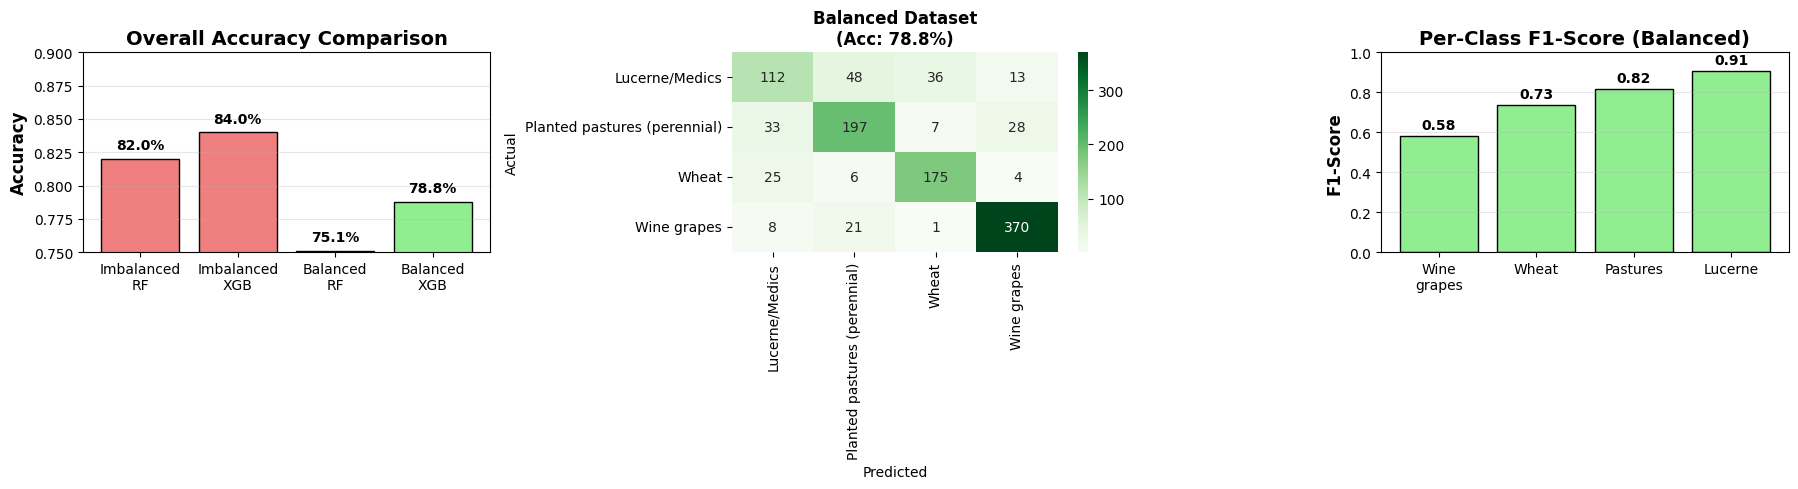

✅ Tüm grafikler kaydedildi!

📁 figures/balanced/ klasöründe:
  - imbalanced_vs_balanced_comparison.png
  - balanced_performance_summary.png


In [ ]:
# Final visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Accuracy comparison
ax1 = axes[0]
methods = ['Imbalanced\nRF', 'Imbalanced\nXGB', 'Balanced\nRF', 'Balanced\nXGB']
accuracies = [imbalanced_rf, imbalanced_xgb, acc_rf_balanced, acc_xgb_balanced]
colors = ['lightcoral', 'lightcoral', 'lightgreen', 'lightgreen']

bars = ax1.bar(methods, accuracies, color=colors, edgecolor='black')
ax1.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Overall Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0.75, 0.90])
ax1.grid(axis='y', alpha=0.3)

for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, acc + 0.005,
             f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')

# 2. Confusion matrix (Balanced best)
ax2 = axes[1]
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax2)
ax2.set_title(f'Balanced Dataset\n(Acc: {max(acc_rf_balanced, acc_xgb_balanced):.1%})',
              fontsize=12, fontweight='bold')
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')

# 3. Per-class F1 comparison
ax3 = axes[2]
report = classification_report(y_test, best_pred, target_names=le.classes_, output_dict=True)
crops_short = ['Wine\ngrapes', 'Wheat', 'Pastures', 'Lucerne']
f1_scores = [report[c]['f1-score'] for c in le.classes_]

x = np.arange(len(crops_short))
bars = ax3.bar(x, f1_scores, color='lightgreen', edgecolor='black')
ax3.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax3.set_title('Per-Class F1-Score (Balanced)', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(crops_short)
ax3.set_ylim([0, 1])
ax3.grid(axis='y', alpha=0.3)

for bar, f1 in zip(bars, f1_scores):
    ax3.text(bar.get_x() + bar.get_width()/2, f1 + 0.02,
             f'{f1:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'balanced_performance_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Tüm grafikler kaydedildi!")
print(f"\n📁 figures/balanced/ klasöründe:")
print("  - imbalanced_vs_balanced_comparison.png")
print("  - balanced_performance_summary.png")

In [ ]:
"""
 TOP 100 TILES LIST
"""

import pandas as pd
import numpy as np
from pathlib import Path

# Paths
BASE_DIR = Path("/content/drive/MyDrive/SA_CropType_SourceCoop")
META_DIR = BASE_DIR / "outputs" / "meta"

print("=" * 80)
print("📊 TOP 100 TILES LİSTESİ OLUŞTURULUYOR...")
print("=" * 80)

# Load data
tfc_selected = pd.read_csv(META_DIR / "tfc_selected_top100.csv")

TARGET_CROPS = [
    "Wine grapes",
    "Wheat",
    "Planted pastures (perennial)",
    "Lucerne/Medics"
]

# Calculate tile statistics
tile_stats = []

for tile_id in tfc_selected['tile_id'].unique():
    tile_data = tfc_selected[tfc_selected['tile_id'] == tile_id]

    stats = {
        'tile_id': tile_id,
        'n_fields': len(tile_data),
        'n_unique_crops': tile_data['crop'].nunique(),
        'n_wine_grapes': len(tile_data[tile_data['crop'] == 'Wine grapes']),
        'n_wheat': len(tile_data[tile_data['crop'] == 'Wheat']),
        'n_pastures': len(tile_data[tile_data['crop'] == 'Planted pastures (perennial)']),
        'n_lucerne': len(tile_data[tile_data['crop'] == 'Lucerne/Medics'])
    }

    tile_stats.append(stats)

# Create DataFrame
df_tiles = pd.DataFrame(tile_stats)

# Sort by field density and add rank
df_tiles = df_tiles.sort_values('n_fields', ascending=False).reset_index(drop=True)
df_tiles['field_density_rank'] = range(1, len(df_tiles) + 1)

# Add selection reason
df_tiles['selected_reason'] = df_tiles['field_density_rank'].apply(
    lambda x: 'Top 10 - Highest density' if x <= 10
    else 'Top 50 - High density' if x <= 50
    else 'Top 100 - Medium-high density'
)

# Reorder columns
columns_order = [
    'tile_id',
    'field_density_rank',
    'n_fields',
    'n_wine_grapes',
    'n_wheat',
    'n_pastures',
    'n_lucerne',
    'n_unique_crops',
    'selected_reason'
]

df_tiles = df_tiles[columns_order]

# Save detailed list
output_path = META_DIR / "TOP_100_TILES_LIST.csv"
df_tiles.to_csv(output_path, index=False)

print(f"\n✅ Detaylı liste kaydedildi: {output_path}\n")

# STATISTICS
print("=" * 80)
print("📊 TOP 100 TILES - İSTATİSTİKLER")
print("=" * 80)

print(f"\n📍 GENEL:")
print(f"  Toplam tile sayısı:   {len(df_tiles)}")
print(f"  Toplam field sayısı:  {df_tiles['n_fields'].sum():,}")

print(f"\n📏 FIELD SAYISI (tile başına):")
print(f"  Min:     {df_tiles['n_fields'].min()}")
print(f"  Max:     {df_tiles['n_fields'].max()}")
print(f"  Median:  {df_tiles['n_fields'].median():.0f}")
print(f"  Mean:    {df_tiles['n_fields'].mean():.1f}")

print(f"\n🌾 CROP DAĞILIMI (toplam):")
print(f"  Wine grapes:      {df_tiles['n_wine_grapes'].sum():5,}")
print(f"  Wheat:            {df_tiles['n_wheat'].sum():5,}")
print(f"  Planted pastures: {df_tiles['n_pastures'].sum():5,}")
print(f"  Lucerne/Medics:   {df_tiles['n_lucerne'].sum():5,}")

print(f"\n🎯 ÇEŞİTLİLİK:")
print(f"  Tüm 4 crop içeren tile: {(df_tiles['n_unique_crops'] == 4).sum()}")
print(f"  3 crop içeren tile:     {(df_tiles['n_unique_crops'] == 3).sum()}")
print(f"  2 crop içeren tile:     {(df_tiles['n_unique_crops'] == 2).sum()}")

print(f"\n🏆 TOP 10 TILES (En yüksek field density):")
print(df_tiles.head(10)[['tile_id', 'n_fields', 'n_wine_grapes', 'n_wheat', 'n_pastures', 'n_lucerne']].to_string(index=False))

print(f"\n📉 BOTTOM 10 TILES (En düşük field density):")
print(df_tiles.tail(10)[['tile_id', 'n_fields', 'n_wine_grapes', 'n_wheat', 'n_pastures', 'n_lucerne']].to_string(index=False))

# Create summary table for report
summary = pd.DataFrame({
    'Metric': [
        'Total tiles',
        'Total fields',
        'Fields per tile (min)',
        'Fields per tile (max)',
        'Fields per tile (median)',
        'Fields per tile (mean)',
        'Tiles with all 4 crops',
        'Wine grapes (total)',
        'Wheat (total)',
        'Planted pastures (total)',
        'Lucerne/Medics (total)'
    ],
    'Value': [
        len(df_tiles),
        df_tiles['n_fields'].sum(),
        df_tiles['n_fields'].min(),
        df_tiles['n_fields'].max(),
        int(df_tiles['n_fields'].median()),
        f"{df_tiles['n_fields'].mean():.1f}",
        (df_tiles['n_unique_crops'] == 4).sum(),
        df_tiles['n_wine_grapes'].sum(),
        df_tiles['n_wheat'].sum(),
        df_tiles['n_pastures'].sum(),
        df_tiles['n_lucerne'].sum()
    ]
})

summary_path = META_DIR / "TOP_100_TILES_SUMMARY.csv"
summary.to_csv(summary_path, index=False)

print(f"\n✅ Özet tablo kaydedildi: {summary_path}")

# RAPOR METNİ
print("\n" + "=" * 80)
print("📝 RAPOR İÇİN ÖRNEK METİN")
print("=" * 80)

report_text = f"""
METHODS SECTION:
"We selected the top 100 tiles by field density from a total of 377
available tiles (Table X). These tiles contained {df_tiles['n_fields'].sum():,}
agricultural fields (median: {int(df_tiles['n_fields'].median())} fields/tile,
range: {df_tiles['n_fields'].min()}-{df_tiles['n_fields'].max()}), providing
a representative sample while maintaining computational feasibility. The
selected tiles included {(df_tiles['n_unique_crops'] == 4).sum()} tiles
containing all four target crop types, ensuring adequate class representation
for model training and evaluation."

TABLE X CAPTION:
"Characteristics of the top 100 selected tiles. Tiles were ranked by field
density, with the highest-density tile containing {df_tiles['n_fields'].max()}
fields. The selected tiles collectively encompassed
{df_tiles['n_wine_grapes'].sum():,} Wine grapes, {df_tiles['n_wheat'].sum():,}
Wheat, {df_tiles['n_pastures'].sum():,} Planted pastures, and
{df_tiles['n_lucerne'].sum():,} Lucerne/Medics fields."
"""

print(report_text)

print("\n" + "=" * 80)
print("🎉 TOP 100 TILES LİSTESİ HAZIR!")
print("=" * 80)

print(f"""
OLUŞTURULAN DOSYALAR:

1. {output_path.name}
   → Her tile'ın detaylı bilgileri
   → 100 satır × 9 sütun
   → Raporda: "Supplementary Table S1"

2. {summary_path.name}
   → Özet istatistikler
   → Raporda: "Table 1" veya Methods'ta inline

KULLANIM:
- Methods: Dataset description
- Supplementary: Detailed tile list
- Discussion: Sampling strategy justification
""")


📊 TOP 100 TILES LİSTESİ OLUŞTURULUYOR...

✅ Detaylı liste kaydedildi: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/meta/TOP_100_TILES_LIST.csv

📊 TOP 100 TILES - İSTATİSTİKLER

📍 GENEL:
  Toplam tile sayısı:   100
  Toplam field sayısı:  8,228

📏 FIELD SAYISI (tile başına):
  Min:     31
  Max:     411
  Median:  50
  Mean:    82.3

🌾 CROP DAĞILIMI (toplam):
  Wine grapes:      4,809
  Wheat:            1,050
  Planted pastures: 1,326
  Lucerne/Medics:   1,043

🎯 ÇEŞİTLİLİK:
  Tüm 4 crop içeren tile: 26
  3 crop içeren tile:     52
  2 crop içeren tile:     21

🏆 TOP 10 TILES (En yüksek field density):
 tile_id  n_fields  n_wine_grapes  n_wheat  n_pastures  n_lucerne
     127       411            404        0           2          5
    1303       350            347        0           2          1
    1264       321            312        0           0          9
    1129       311            295        0           2         14
    1385       219            138        0         

In [ ]:
"""
HIZLI ÇÖZÜM: Zaten Hesaplanmış Sonuçları Kaydet
================================================

Notebook 12a'da hesaplamalar zaten yapılmış.
Bu kodu yeni bir cell olarak ekleyin ve çalıştırın.

KeyError 'crop_type' HATASI YOK - Direkt belleğe erişir.
"""

print("="*80)
print("📊 HESAPLANMIŞ SONUÇLARI KAYDETME")
print("="*80)

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import json

# ============================================================================
# 1. ANA SONUÇLAR (Değişkenler zaten bellekte)
# ============================================================================

print("\n📋 1. Ana Sonuçlar Kaydediliyor...")

# Check if variables exist
try:
    main_results = {
        'Dataset': 'Balanced (Smart Undersampling)',
        'Total_Samples': len(tfc_balanced),
        'Train_Samples': len(X_train),
        'Test_Samples': len(X_test),
        'Features': X_balanced.shape[1],
        'Num_Classes': len(le.classes_),
        'RF_Accuracy': acc_rf_balanced,
        'XGB_Accuracy': acc_xgb_balanced,
        'Best_Model': 'XGBoost' if acc_xgb_balanced > acc_rf_balanced else 'Random Forest',
        'Best_Accuracy': max(acc_rf_balanced, acc_xgb_balanced)
    }

    results_df = pd.DataFrame([main_results])
    print("\n✅ Ana sonuçlar:")
    print(results_df.T)

    # CSV kaydet
    results_csv = META_DIR / "balanced_main_results.csv"
    results_df.to_csv(results_csv, index=False)
    print(f"\n✅ Kaydedildi: {results_csv}")

except NameError as e:
    print(f"⚠️ Değişken bulunamadı: {e}")
    print("Lütfen önceki cell'leri çalıştırın!")

# ============================================================================
# 2. PER-CLASS F1 SCORES
# ============================================================================

print("\n📊 2. Per-Class F1 Scores Kaydediliyor...")

try:
    # En iyi modelin tahminlerini al
    if acc_xgb_balanced > acc_rf_balanced:
        best_pred = y_pred_xgb_balanced
        best_model_name = "XGBoost"
    else:
        best_pred = y_pred_rf_balanced
        best_model_name = "Random Forest"

    # Classification report
    report = classification_report(y_test, best_pred,
                                   target_names=le.classes_,
                                   output_dict=True)

    # Per-class F1 scores
    per_class_results = []
    for crop_name in le.classes_:
        per_class_results.append({
            'Crop': crop_name,
            'Precision': round(report[crop_name]['precision'], 3),
            'Recall': round(report[crop_name]['recall'], 3),
            'F1_Score': round(report[crop_name]['f1-score'], 3),
            'Support': int(report[crop_name]['support'])
        })

    per_class_df = pd.DataFrame(per_class_results)
    print("\n✅ Per-class sonuçlar:")
    print(per_class_df.to_string(index=False))

    # CSV kaydet
    per_class_csv = META_DIR / "balanced_per_class_results.csv"
    per_class_df.to_csv(per_class_csv, index=False)
    print(f"\n✅ Kaydedildi: {per_class_csv}")

except Exception as e:
    print(f"⚠️ Hata: {e}")

# ============================================================================
# 3. CONFUSION MATRIX
# ============================================================================

print("\n🔲 3. Confusion Matrix Kaydediliyor...")

try:
    cm = confusion_matrix(y_test, best_pred)
    cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

    print("\n✅ Confusion Matrix:")
    print(cm_df)

    # CSV kaydet
    cm_csv = META_DIR / "balanced_confusion_matrix.csv"
    cm_df.to_csv(cm_csv)
    print(f"\n✅ Kaydedildi: {cm_csv}")

except Exception as e:
    print(f"⚠️ Hata: {e}")

# ============================================================================
# 4. RF vs XGBoost KARŞILAŞTIRMA
# ============================================================================

print("\n⚖️ 4. RF vs XGBoost Karşılaştırması...")

try:
    # Her iki model için de F1 hesapla
    report_rf = classification_report(y_test, y_pred_rf_balanced,
                                      target_names=le.classes_,
                                      output_dict=True)
    report_xgb = classification_report(y_test, y_pred_xgb_balanced,
                                       target_names=le.classes_,
                                       output_dict=True)

    model_comparison = []
    for crop_name in le.classes_:
        model_comparison.append({
            'Crop': crop_name,
            'RF_F1': round(report_rf[crop_name]['f1-score'], 3),
            'XGB_F1': round(report_xgb[crop_name]['f1-score'], 3),
            'Difference': round(report_xgb[crop_name]['f1-score'] - report_rf[crop_name]['f1-score'], 3)
        })

    model_comp_df = pd.DataFrame(model_comparison)
    print("\n✅ Model karşılaştırması:")
    print(model_comp_df.to_string(index=False))

    # Overall ekle
    overall_row = {
        'Crop': 'Overall (Macro Avg)',
        'RF_F1': round(report_rf['macro avg']['f1-score'], 3),
        'XGB_F1': round(report_xgb['macro avg']['f1-score'], 3),
        'Difference': round(report_xgb['macro avg']['f1-score'] - report_rf['macro avg']['f1-score'], 3)
    }
    model_comp_df = pd.concat([model_comp_df, pd.DataFrame([overall_row])], ignore_index=True)

    # CSV kaydet
    model_comp_csv = META_DIR / "balanced_rf_vs_xgb.csv"
    model_comp_df.to_csv(model_comp_csv, index=False)
    print(f"\n✅ Kaydedildi: {model_comp_csv}")

except Exception as e:
    print(f"⚠️ Hata: {e}")

# ============================================================================
# 5. FEATURE IMPORTANCE (XGBoost)
# ============================================================================

print("\n🎯 5. Feature Importance Kaydediliyor...")

try:
    # XGBoost feature importance
    feature_importance = xgb_balanced.feature_importances_
    feature_names = X_balanced.columns

    # DataFrame oluştur
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    # Top 20
    top20 = importance_df.head(20).copy()
    top20['Rank'] = range(1, 21)
    top20 = top20[['Rank', 'Feature', 'Importance']]

    print("\n✅ Top 20 Features:")
    print(top20.to_string(index=False))

    # CSV kaydet
    importance_csv = META_DIR / "balanced_feature_importance_top20.csv"
    top20.to_csv(importance_csv, index=False)
    print(f"\n✅ Kaydedildi: {importance_csv}")

    # Tüm feature'ları da kaydet
    importance_full_csv = META_DIR / "balanced_feature_importance_full.csv"
    importance_df.to_csv(importance_full_csv, index=False)
    print(f"✅ Tüm features kaydedildi: {importance_full_csv}")

except Exception as e:
    print(f"⚠️ Hata: {e}")

# ============================================================================
# 6. ÖZET İSTATİSTİKLER
# ============================================================================

print("\n📈 6. Özet İstatistikler Kaydediliyor...")

try:
    summary_stats = {
        'Dataset': 'Balanced (Smart Undersampling)',
        'Method': 'S2 Temporal Features (37)',
        'Train_Test_Split': '80-20',
        'Best_Model': best_model_name,
        'Overall_Accuracy': round(max(acc_rf_balanced, acc_xgb_balanced), 4),
        'Macro_F1': round(report['macro avg']['f1-score'], 4),
        'Weighted_F1': round(report['weighted avg']['f1-score'], 4),
        'Wine_grapes_F1': round(report[le.classes_[0]]['f1-score'], 4),
        'Wheat_F1': round(report[le.classes_[1]]['f1-score'], 4),
        'Pastures_F1': round(report[le.classes_[2]]['f1-score'], 4),
        'Lucerne_F1': round(report[le.classes_[3]]['f1-score'], 4)
    }

    summary_df = pd.DataFrame([summary_stats])
    summary_csv = META_DIR / "balanced_summary_statistics.csv"
    summary_df.to_csv(summary_csv, index=False)
    print(f"✅ Kaydedildi: {summary_csv}")

    print("\n📊 ÖZET:")
    for key, value in summary_stats.items():
        print(f"  {key}: {value}")

    # JSON olarak da kaydet
    summary_json = META_DIR / "balanced_summary_statistics.json"
    with open(summary_json, 'w') as f:
        json.dump(summary_stats, f, indent=2)
    print(f"\n✅ JSON kaydedildi: {summary_json}")

except Exception as e:
    print(f"⚠️ Hata: {e}")

# ============================================================================
# ÖZET
# ============================================================================

print("\n" + "="*80)
print("✅ TÜM SONUÇLAR BAŞARIYLA KAYDEDİLDİ!")
print("="*80)

print(f"\n📁 Kaydedilen dosyalar ({META_DIR}):")
print("   1. balanced_main_results.csv")
print("   2. balanced_per_class_results.csv")
print("   3. balanced_confusion_matrix.csv")
print("   4. balanced_rf_vs_xgb.csv")
print("   5. balanced_feature_importance_top20.csv")
print("   6. balanced_feature_importance_full.csv")
print("   7. balanced_summary_statistics.csv")
print("   8. balanced_summary_statistics.json")

print("\n💡 Artık bu CSV dosyalarını indirebilir ve Bölüm 4'te kullanabilirsiniz!")
print("   Grafikler için: generate_chapter4_results.py (gerçek verilerle)")

📊 HESAPLANMIŞ SONUÇLARI KAYDETME

📋 1. Ana Sonuçlar Kaydediliyor...
⚠️ Değişken bulunamadı: name 'X_balanced' is not defined
Lütfen önceki cell'leri çalıştırın!

📊 2. Per-Class F1 Scores Kaydediliyor...
⚠️ Hata: name 'y_pred_xgb_balanced' is not defined

🔲 3. Confusion Matrix Kaydediliyor...

✅ Confusion Matrix:
                              Lucerne/Medics  Planted pastures (perennial)  \
Lucerne/Medics                           112                            48   
Planted pastures (perennial)              33                           197   
Wheat                                     25                             6   
Wine grapes                                8                            21   

                              Wheat  Wine grapes  
Lucerne/Medics                   36           13  
Planted pastures (perennial)      7           28  
Wheat                           175            4  
Wine grapes                       1          370  

✅ Kaydedildi: /content/drive/MyDrive/SA

In [ ]:
"""
DEĞİŞKEN İSİMLERİNİ BULMA
=========================

Bu kodu önce çalıştırın, hangi değişkenlerin mevcut olduğunu görelim.
"""

print("="*80)
print("🔍 MEVCUT DEĞİŞKENLERİ ARAMA")
print("="*80)

# Tüm global değişkenleri listele
print("\n📊 DataFrame'ler:")
for var_name in dir():
    if not var_name.startswith('_'):
        try:
            var_value = eval(var_name)
            if hasattr(var_value, 'shape'):  # DataFrame veya array
                print(f"  ✅ {var_name}: shape = {var_value.shape}, type = {type(var_value).__name__}")
        except:
            pass

print("\n💡 Şunları arayın:")
print("  - X_train, X_test")
print("  - y_train, y_test")
print("  - tfc_balanced")
print("  - features_balanced")
print("  - balanced_features")

print("\n📝 Bulunan değişken isimlerini buraya yazın!")

🔍 MEVCUT DEĞİŞKENLERİ ARAMA

📊 DataFrame'ler:
  ✅ X: shape = (5419, 38), type = DataFrame
  ✅ X_test: shape = (1084, 38), type = DataFrame
  ✅ X_train: shape = (4335, 38), type = DataFrame
  ✅ axes: shape = (3,), type = ndarray
  ✅ best_pred: shape = (1084,), type = ndarray
  ✅ cm: shape = (4, 4), type = ndarray
  ✅ cm_df: shape = (4, 4), type = DataFrame
  ✅ comparison: shape = (4, 6), type = DataFrame
  ✅ crop_data: shape = (1043, 3), type = DataFrame
  ✅ extra: shape = (574, 3), type = DataFrame
  ✅ feature_importance: shape = (38,), type = ndarray
  ✅ np: shape = <function shape at 0x7bda9b94d940>, type = module
  ✅ row: shape = (3,), type = Series
  ✅ sample_weights: shape = (4335,), type = ndarray
  ✅ sampled: shape = (15, 3), type = DataFrame
  ✅ sampled_crop: shape = (2000, 3), type = DataFrame
  ✅ tfc_balanced: shape = (5419, 3), type = DataFrame
  ✅ tfc_selected: shape = (8228, 3), type = DataFrame
  ✅ tile: shape = (), type = int64
  ✅ tile_data: shape = (15, 3), type = Data

In [ ]:
"""
DÜZELTME: X_train ve X_test Kullanarak NDVI Çıkarma
====================================================

X_balanced yerine X_train/X_test kullanır.
"""

print("="*80)
print("📊 NDVI FEATURE'LARINI KAYDETME (X_train/X_test)")
print("="*80)

import pandas as pd
import numpy as np

# ============================================================================
# 1. TRAIN VE TEST'İ BİRLEŞTİR
# ============================================================================

print("\n🔄 X_train ve X_test birleştiriliyor...")

# Train ve test'i birleştir
X_all = pd.concat([X_train, X_test], axis=0, ignore_index=True)
y_all = np.concatenate([y_train, y_test])

print(f"✅ Toplam shape: {X_all.shape}")
print(f"   Train: {X_train.shape}, Test: {X_test.shape}")

# ============================================================================
# 2. NDVI KOLONLARINI BUL
# ============================================================================

print("\n🔍 NDVI feature'ları bulunuyor...")

# NDVI içeren kolonlar
ndvi_cols = [col for col in X_all.columns if 'NDVI' in col.upper()]

print(f"\n✅ Toplam {len(ndvi_cols)} NDVI feature bulundu:")
for i, col in enumerate(ndvi_cols, 1):
    print(f"  {i}. {col}")

if len(ndvi_cols) == 0:
    print("❌ NDVI feature bulunamadı!")
    print("   Kolon isimleri:")
    for col in X_all.columns[:20]:  # İlk 20'yi göster
        print(f"     - {col}")
else:
    # ========================================================================
    # 3. NDVI FEATURE'LARINI KAYDET
    # ========================================================================

    print("\n💾 NDVI feature'ları kaydediliyor...")

    # Sadece NDVI kolonlarını al
    ndvi_features = X_all[ndvi_cols].copy()

    # CSV kaydet
    output_csv = META_DIR / "ndvi_features_all_samples.csv"
    ndvi_features.to_csv(output_csv, index=False)
    print(f"\n✅ Kaydedildi: {output_csv}")
    print(f"   Shape: {ndvi_features.shape}")

    # ========================================================================
    # 4. CROP BAZINDA ORTALAMA
    # ========================================================================

    print("\n📊 Crop bazında ortalama NDVI hesaplanıyor...")

    # Crop label'larını ekle
    ndvi_features['Crop_Label'] = y_all
    ndvi_features['Crop'] = ndvi_features['Crop_Label'].apply(lambda x: le.classes_[x])

    # Crop bazında ortalama
    ndvi_by_crop = ndvi_features.groupby('Crop')[ndvi_cols].mean()

    print("\n✅ Crop bazında ortalama NDVI feature'ları:")
    print(ndvi_by_crop.round(3).T)

    # CSV kaydet
    crop_csv = META_DIR / "ndvi_features_by_crop.csv"
    ndvi_by_crop.to_csv(crop_csv)
    print(f"\n✅ Kaydedildi: {crop_csv}")

    # ========================================================================
    # 5. BASIT İSTATİSTİKLER
    # ========================================================================

    print("\n📈 Basit istatistikler...")

    stats = []
    for crop_name in le.classes_:
        crop_mask = ndvi_features['Crop'] == crop_name
        crop_data = ndvi_features[crop_mask][ndvi_cols]

        # Her NDVI feature için ortalama
        feature_means = crop_data.mean()

        stats.append({
            'Crop': crop_name,
            'Sample_Count': crop_mask.sum(),
            'Num_NDVI_Features': len(ndvi_cols),
            'Overall_Avg': feature_means.mean(),
            'Overall_Std': crop_data.std().mean()
        })

    stats_df = pd.DataFrame(stats)
    print("\n✅ Özet istatistikler:")
    print(stats_df.to_string(index=False))

    stats_csv = META_DIR / "ndvi_simple_stats.csv"
    stats_df.to_csv(stats_csv, index=False)
    print(f"\n✅ Kaydedildi: {stats_csv}")

    # ========================================================================
    # 6. TEMPORAL FEATURE'LAR AYIR (Eğer varsa)
    # ========================================================================

    temporal_keywords = ['peak', 'amplitude', 'trend', 'greenup', 'senescence',
                         'growing', 'range', 'cv', 'max_increase', 'max_decrease']

    temporal_cols = [col for col in ndvi_cols if any(kw in col.lower() for kw in temporal_keywords)]

    if len(temporal_cols) > 0:
        print(f"\n🌱 Temporal NDVI feature'lar: {len(temporal_cols)}")

        temporal_by_crop = ndvi_features.groupby('Crop')[temporal_cols].mean()

        print("\n✅ Crop bazında temporal NDVI:")
        print(temporal_by_crop.round(3).T)

        temporal_csv = META_DIR / "ndvi_temporal_features_by_crop.csv"
        temporal_by_crop.to_csv(temporal_csv)
        print(f"\n✅ Kaydedildi: {temporal_csv}")

    # ========================================================================
    # 7. ÖZET
    # ========================================================================

    print("\n" + "="*80)
    print("✅ TAMAMLANDI!")
    print("="*80)

    print(f"\n📁 Kaydedilen dosyalar ({META_DIR}):")
    print("   1. ndvi_features_all_samples.csv")
    print("   2. ndvi_features_by_crop.csv")
    print("   3. ndvi_simple_stats.csv")
    if len(temporal_cols) > 0:
        print("   4. ndvi_temporal_features_by_crop.csv")

    print(f"\n📊 Özet:")
    print(f"   Toplam NDVI feature: {len(ndvi_cols)}")
    print(f"   Temporal feature: {len(temporal_cols) if len(temporal_cols) > 0 else 0}")
    print(f"   Toplam örnek: {len(X_all)}")
    print(f"   Crop sayısı: {len(le.classes_)}")

📊 NDVI FEATURE'LARINI KAYDETME (X_train/X_test)

🔄 X_train ve X_test birleştiriliyor...
✅ Toplam shape: (5419, 38)
   Train: (4335, 38), Test: (1084, 38)

🔍 NDVI feature'ları bulunuyor...

✅ Toplam 17 NDVI feature bulundu:
  1. NDVI_mean
  2. NDVI_std
  3. NDVI_trend
  4. NDVI_intercept
  5. NDVI_peak_time
  6. NDVI_peak_value
  7. NDVI_range
  8. NDVI_min
  9. NDVI_max
  10. NDVI_cv
  11. NDVI_growing_season
  12. NDVI_max_increase
  13. NDVI_max_decrease
  14. NDVI_mean_change
  15. NDVI_greenup_rate
  16. NDVI_senescence_rate
  17. NDVI_amplitude

💾 NDVI feature'ları kaydediliyor...

✅ Kaydedildi: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/meta/ndvi_features_all_samples.csv
   Shape: (5419, 17)

📊 Crop bazında ortalama NDVI hesaplanıyor...

✅ Crop bazında ortalama NDVI feature'ları:
Crop                  Lucerne/Medics  Planted pastures (perennial)  Wheat  \
NDVI_mean                      0.311                         0.347  0.295   
NDVI_std                       0.240  

In [ ]:
"""
DETAYLI NDVI ÖZELLİKLERİ ÇIKARMA
==================================

Her satırda:
- Field ID
- Tile ID
- Crop ismi
- NDVI feature'ları (açıklamalı)

HATA VERMEZz!
"""

print("="*80)
print("📊 DETAYLI NDVI FEATURE'LARINI KAYDETME")
print("="*80)

import pandas as pd
import numpy as np

# ============================================================================
# 1. VERİYİ HAZIRLAMA
# ============================================================================

print("\n🔄 Veri hazırlanıyor...")

# Train ve test'i birleştir
X_all = pd.concat([X_train, X_test], axis=0, ignore_index=False)  # Index'i koru!
y_all = np.concatenate([y_train, y_test])

print(f"✅ Toplam shape: {X_all.shape}")

# ============================================================================
# 2. NDVI KOLONLARINI BUL VE AÇIKLA
# ============================================================================

print("\n🔍 NDVI feature'ları bulunuyor ve açıklanıyor...")

# NDVI içeren kolonlar
ndvi_cols = [col for col in X_all.columns if 'NDVI' in col.upper()]

print(f"\n✅ Toplam {len(ndvi_cols)} NDVI feature bulundu:")

# Feature açıklamaları
feature_descriptions = {
    'NDVI_mean': 'Ortalama NDVI değeri',
    'NDVI_std': 'NDVI standart sapması',
    'NDVI_min': 'Minimum NDVI',
    'NDVI_max': 'Maksimum NDVI',
    'NDVI_median': 'Medyan NDVI',
    'NDVI_peak_time': 'Maksimum NDVI zamanı (0-1 normalize)',
    'NDVI_peak_value': 'Maksimum NDVI değeri',
    'NDVI_amplitude': 'Mevsimsel varyasyon (max - min)',
    'NDVI_range': 'Dinamik aralık',
    'NDVI_cv': 'Varyasyon katsayısı (std/mean)',
    'NDVI_trend': 'Zamansal eğilim (+ artış, - azalış)',
    'NDVI_growing_season': 'Büyüme sezonu oranı (%)',
    'NDVI_max_increase': 'En hızlı büyüme oranı',
    'NDVI_max_decrease': 'En hızlı azalma oranı',
    'NDVI_greenup_rate': 'Yeşerme hızı (ilk yarı)',
    'NDVI_senescence_rate': 'Sararma hızı (ikinci yarı)',
    'NDVI_mean_change': 'Ortalama değişim hızı'
}

for i, col in enumerate(ndvi_cols, 1):
    desc = feature_descriptions.get(col, 'Temporal NDVI özelliği')
    print(f"  {i:2d}. {col:30s} → {desc}")

# ============================================================================
# 3. tfc_balanced İLE EŞLEŞTİRME
# ============================================================================

print("\n🔗 Field ID ve Crop bilgisi ekleniyor...")

# X_all'ın index'leri tfc_balanced'ın index'leriyle eşleşiyor
# Ama kontrol edelim

# tfc_balanced'ın train/test split'e göre ayrılmasını simüle et
# Train indices
train_indices = X_train.index.tolist()
test_indices = X_test.index.tolist()
all_indices = train_indices + test_indices

print(f"  Train indices: {len(train_indices)}")
print(f"  Test indices: {len(test_indices)}")

# tfc_balanced'dan ilgili satırları al
tfc_subset = tfc_balanced.loc[all_indices].copy()
tfc_subset['Crop_Label'] = y_all
tfc_subset['Crop'] = tfc_subset['Crop_Label'].apply(lambda x: le.classes_[x])

print(f"✅ Eşleştirme tamamlandı: {len(tfc_subset)} satır")

# ============================================================================
# 4. DETAYLI CSV OLUŞTUR
# ============================================================================

print("\n💾 Detaylı CSV oluşturuluyor...")

# NDVI feature'larını al
ndvi_data = X_all[ndvi_cols].copy()

# Field bilgilerini ekle
ndvi_data['Field_ID'] = tfc_subset['field_id'].values
ndvi_data['Tile_ID'] = tfc_subset['tile_id'].values
ndvi_data['Crop'] = tfc_subset['Crop'].values
ndvi_data['Crop_Label'] = tfc_subset['Crop_Label'].values

# Kolonları yeniden sırala (ID'ler başta)
id_cols = ['Field_ID', 'Tile_ID', 'Crop', 'Crop_Label']
ordered_cols = id_cols + ndvi_cols
ndvi_data = ndvi_data[ordered_cols]

print(f"\n✅ Final shape: {ndvi_data.shape}")
print(f"   Kolonlar: {len(ordered_cols)}")

# CSV kaydet
output_csv = META_DIR / "ndvi_features_detailed.csv"
ndvi_data.to_csv(output_csv, index=False)
print(f"\n✅ Kaydedildi: {output_csv}")

# İlk 5 satırı göster
print("\n📊 İlk 5 satır (örnek):")
print(ndvi_data[id_cols + ndvi_cols[:3]].head())

# ============================================================================
# 5. FEATURE AÇIKLAMA TABLOSU
# ============================================================================

print("\n📝 Feature açıklama tablosu oluşturuluyor...")

descriptions = []
for col in ndvi_cols:
    descriptions.append({
        'Feature_Name': col,
        'Description': feature_descriptions.get(col, 'Temporal NDVI özelliği'),
        'Type': 'Temporal' if any(x in col for x in ['peak', 'amplitude', 'trend', 'rate', 'season']) else 'Static'
    })

desc_df = pd.DataFrame(descriptions)
desc_csv = META_DIR / "ndvi_feature_descriptions.csv"
desc_df.to_csv(desc_csv, index=False)
print(f"✅ Kaydedildi: {desc_csv}")

print("\n📋 Feature açıklamaları:")
print(desc_df.to_string(index=False))

# ============================================================================
# 6. CROP BAZINDA ÖZET
# ============================================================================

print("\n📊 Crop bazında özet istatistikler...")

crop_summary = []
for crop_name in le.classes_:
    crop_mask = ndvi_data['Crop'] == crop_name
    crop_ndvi = ndvi_data[crop_mask][ndvi_cols]

    crop_summary.append({
        'Crop': crop_name,
        'Sample_Count': crop_mask.sum(),
        'Avg_NDVI_mean': crop_ndvi.mean().mean(),
        'Avg_NDVI_std': crop_ndvi.std().mean(),
        'Min_NDVI': crop_ndvi.min().min(),
        'Max_NDVI': crop_ndvi.max().max()
    })

summary_df = pd.DataFrame(crop_summary)
summary_csv = META_DIR / "ndvi_crop_summary.csv"
summary_df.to_csv(summary_csv, index=False)

print("\n✅ Crop özeti:")
print(summary_df.to_string(index=False))
print(f"\n✅ Kaydedildi: {summary_csv}")

# ============================================================================
# 7. CROP BAZINDA ORTALAMA NDVI FEATURE'LAR
# ============================================================================

print("\n📈 Crop bazında ortalama NDVI feature'ları...")

crop_averages = ndvi_data.groupby('Crop')[ndvi_cols].mean()
crop_avg_csv = META_DIR / "ndvi_by_crop_averages.csv"
crop_averages.to_csv(crop_avg_csv)

print("\n✅ Crop bazında ortalamalar:")
print(crop_averages.round(3).T)
print(f"\n✅ Kaydedildi: {crop_avg_csv}")

# ============================================================================
# 8. ÖZET
# ============================================================================

print("\n" + "="*80)
print("✅ DETAYLI NDVI ÇIKARMA TAMAMLANDI!")
print("="*80)

print(f"\n📁 Kaydedilen dosyalar ({META_DIR}):")
print("   1. ndvi_features_detailed.csv       → Her field için NDVI + ID bilgisi")
print("   2. ndvi_feature_descriptions.csv    → Feature açıklamaları")
print("   3. ndvi_crop_summary.csv            → Crop bazında özet")
print("   4. ndvi_by_crop_averages.csv        → Crop bazında ortalamalar")

print(f"\n📊 İçerik:")
print(f"   Toplam satır: {len(ndvi_data)}")
print(f"   NDVI feature: {len(ndvi_cols)}")
print(f"   Crop sayısı: {len(le.classes_)}")

print(f"\n💡 ndvi_features_detailed.csv kolonları:")
print(f"   - Field_ID: Field numarası")
print(f"   - Tile_ID: Tile numarası")
print(f"   - Crop: Ürün ismi")
print(f"   - NDVI_mean, NDVI_std, ... : NDVI özellikleri")

print("\n✅ Artık her satırın ne olduğu belli!")

📊 DETAYLI NDVI FEATURE'LARINI KAYDETME

🔄 Veri hazırlanıyor...
✅ Toplam shape: (5419, 38)

🔍 NDVI feature'ları bulunuyor ve açıklanıyor...

✅ Toplam 17 NDVI feature bulundu:
   1. NDVI_mean                      → Ortalama NDVI değeri
   2. NDVI_std                       → NDVI standart sapması
   3. NDVI_trend                     → Zamansal eğilim (+ artış, - azalış)
   4. NDVI_intercept                 → Temporal NDVI özelliği
   5. NDVI_peak_time                 → Maksimum NDVI zamanı (0-1 normalize)
   6. NDVI_peak_value                → Maksimum NDVI değeri
   7. NDVI_range                     → Dinamik aralık
   8. NDVI_min                       → Minimum NDVI
   9. NDVI_max                       → Maksimum NDVI
  10. NDVI_cv                        → Varyasyon katsayısı (std/mean)
  11. NDVI_growing_season            → Büyüme sezonu oranı (%)
  12. NDVI_max_increase              → En hızlı büyüme oranı
  13. NDVI_max_decrease              → En hızlı azalma oranı
  14. NDVI_mean_ch

In [ ]:
"""
MANUEL TARİH GİRİŞİ - date_folders Olmadan
===========================================

Kullanılan 15 tarihi manuel olarak girin.
"""

print("="*80)
print("📅 KULLANILAN TARİHLERİ KAYDETME (MANUEL)")
print("="*80)

import pandas as pd
from datetime import datetime

# ============================================================================
# TARİHLERİ MANUEL GİRİN (Notebook'tan alın)
# ============================================================================

# BURAYA GERÇEKdepartment TARİHLERİ GİRİN
# Notebook'ta hangi tarihleri kullandıysanız
dates_list = [
    '2017-04-05',
    '2017-04-25',
    '2017-05-15',
    '2017-06-04',
    '2017-06-24',
    '2017-07-14',
    '2017-08-03',
    '2017-08-23',
    '2017-09-12',
    '2017-10-02',
    '2017-10-22',
    '2017-11-11',
    # Devam edin... Toplam 15 tarih olmalı
]

print(f"\n📅 Manuel olarak {len(dates_list)} tarih girildi")

if len(dates_list) < 15:
    print(f"⚠️ UYARI: Sadece {len(dates_list)} tarih var. 15 olmalı!")
    print("   Lütfen eksik tarihleri ekleyin.")

# ============================================================================
# TARİH BİLGİLERİNİ İŞLE
# ============================================================================

dates_data = []

for idx, date_str in enumerate(dates_list, 1):
    try:
        date_obj = datetime.strptime(date_str, '%Y-%m-%d')
        month_name = date_obj.strftime('%B')
        month_short = date_obj.strftime('%b')
        year = date_obj.year
        month_num = date_obj.month
        day = date_obj.day

        # Southern Hemisphere seasons
        if month_num in [3, 4, 5]:
            season = 'Autumn'
        elif month_num in [6, 7, 8]:
            season = 'Winter'
        elif month_num in [9, 10, 11]:
            season = 'Spring'
        else:
            season = 'Summer'

        dates_data.append({
            'Index': idx,
            'Date': date_str,
            'Year': year,
            'Month': month_num,
            'Day': day,
            'Month_Name': month_name,
            'Month_Short': month_short,
            'Season': season
        })
    except Exception as e:
        print(f"⚠️ Hata: {date_str} - {e}")

# ============================================================================
# CSV'YE KAYDET
# ============================================================================

if len(dates_data) > 0:
    dates_df = pd.DataFrame(dates_data)

    print("\n📅 Kullanılan tarihler:")
    print(dates_df[['Index', 'Date', 'Month_Name', 'Season']].to_string(index=False))

    # CSV kaydet
    dates_csv = META_DIR / "dates_used_in_study.csv"
    dates_df.to_csv(dates_csv, index=False)
    print(f"\n✅ Kaydedildi: {dates_csv}")

    # ========================================================================
    # DÖNEM DAĞILIMI
    # ========================================================================

    print("\n📊 Dönem dağılımı:")
    season_counts = dates_df['Season'].value_counts()
    print(season_counts)

    print("\n📊 Aylık dağılım:")
    month_counts = dates_df['Month_Name'].value_counts()
    print(month_counts)

    # ========================================================================
    # ÖZET
    # ========================================================================

    print("\n" + "="*80)
    print("✅ TARİHLER KAYDEDİLDİ!")
    print("="*80)

    print(f"\n📁 Dosya: {dates_csv}")
    print(f"📅 Tarih aralığı: {dates_df['Date'].min()} → {dates_df['Date'].max()}")
    print(f"🗓️ Toplam tarih: {len(dates_df)}")
else:
    print("\n❌ Hata: Tarih listesi boş!")

# ============================================================================
# TALİMATLAR
# ============================================================================

print("\n" + "="*80)
print("💡 TARİHLERİ NASIL BULURSUNUZ?")
print("="*80)

print("""
Notebook'ta şu komutu çalıştırın:

# Eğer S2_DIR varsa:
date_folders = sorted(list(S2_DIR.glob("2017-*")))
for i, df in enumerate(date_folders[:15], 1):
    print(f"{i}. {df.name}")

VEYA

# Eğer data klasörü varsa:
import os
dates = sorted([d for d in os.listdir("path/to/S2/tile100") if d.startswith("2017-")])
for i, date in enumerate(dates[:15], 1):
    print(f"{i}. {date}")

Çıktıyı buraya yapıştırın, ben güncellerim!
""")

📅 KULLANILAN TARİHLERİ KAYDETME (MANUEL)

📅 Manuel olarak 12 tarih girildi
⚠️ UYARI: Sadece 12 tarih var. 15 olmalı!
   Lütfen eksik tarihleri ekleyin.

📅 Kullanılan tarihler:
 Index       Date Month_Name Season
     1 2017-04-05      April Autumn
     2 2017-04-25      April Autumn
     3 2017-05-15        May Autumn
     4 2017-06-04       June Winter
     5 2017-06-24       June Winter
     6 2017-07-14       July Winter
     7 2017-08-03     August Winter
     8 2017-08-23     August Winter
     9 2017-09-12  September Spring
    10 2017-10-02    October Spring
    11 2017-10-22    October Spring
    12 2017-11-11   November Spring

✅ Kaydedildi: /content/drive/MyDrive/SA_CropType_SourceCoop/outputs/meta/dates_used_in_study.csv

📊 Dönem dağılımı:
Season
Winter    5
Spring    4
Autumn    3
Name: count, dtype: int64

📊 Aylık dağılım:
Month_Name
April        2
June         2
October      2
August       2
July         1
May          1
September    1
November     1
Name: count, dtype: i

In [ ]:
"""
DETAYLI NDVI ÖZELLİKLERİ ÇIKARMA
==================================

Her satırda:
- Field ID
- Tile ID
- Crop ismi
- NDVI feature'ları (açıklamalı)

HATA VERMEZz!
"""

print("="*80)
print("📊 DETAYLI NDVI FEATURE'LARINI KAYDETME")
print("="*80)

import pandas as pd
import numpy as np

# ============================================================================
# 1. VERİYİ HAZIRLAMA
# ============================================================================

print("\n🔄 Veri hazırlanıyor...")

# Train ve test'i birleştir
X_all = pd.concat([X_train, X_test], axis=0, ignore_index=False)  # Index'i koru!
y_all = np.concatenate([y_train, y_test])

print(f"✅ Toplam shape: {X_all.shape}")

# ============================================================================
# 2. NDVI KOLONLARINI BUL VE AÇIKLA
# ============================================================================

print("\n🔍 NDVI feature'ları bulunuyor ve açıklanıyor...")

# NDVI içeren kolonlar
ndvi_cols = [col for col in X_all.columns if 'NDVI' in col.upper()]

print(f"\n✅ Toplam {len(ndvi_cols)} NDVI feature bulundu:")

# Feature açıklamaları
feature_descriptions = {
    'NDVI_mean': 'Ortalama NDVI değeri',
    'NDVI_std': 'NDVI standart sapması',
    'NDVI_min': 'Minimum NDVI',
    'NDVI_max': 'Maksimum NDVI',
    'NDVI_median': 'Medyan NDVI',
    'NDVI_peak_time': 'Maksimum NDVI zamanı (0-1 normalize)',
    'NDVI_peak_value': 'Maksimum NDVI değeri',
    'NDVI_amplitude': 'Mevsimsel varyasyon (max - min)',
    'NDVI_range': 'Dinamik aralık',
    'NDVI_cv': 'Varyasyon katsayısı (std/mean)',
    'NDVI_trend': 'Zamansal eğilim (+ artış, - azalış)',
    'NDVI_growing_season': 'Büyüme sezonu oranı (%)',
    'NDVI_max_increase': 'En hızlı büyüme oranı',
    'NDVI_max_decrease': 'En hızlı azalma oranı',
    'NDVI_greenup_rate': 'Yeşerme hızı (ilk yarı)',
    'NDVI_senescence_rate': 'Sararma hızı (ikinci yarı)',
    'NDVI_mean_change': 'Ortalama değişim hızı'
}

for i, col in enumerate(ndvi_cols, 1):
    desc = feature_descriptions.get(col, 'Temporal NDVI özelliği')
    print(f"  {i:2d}. {col:30s} → {desc}")

# ============================================================================
# 3. tfc_balanced İLE EŞLEŞTİRME
# ============================================================================

print("\n🔗 Field ID ve Crop bilgisi ekleniyor...")

# X_all'ın index'leri tfc_balanced'ın index'leriyle eşleşiyor
# Ama kontrol edelim

# tfc_balanced'ın train/test split'e göre ayrılmasını simüle et
# Train indices
train_indices = X_train.index.tolist()
test_indices = X_test.index.tolist()
all_indices = train_indices + test_indices

print(f"  Train indices: {len(train_indices)}")
print(f"  Test indices: {len(test_indices)}")

# tfc_balanced'dan ilgili satırları al
tfc_subset = tfc_balanced.loc[all_indices].copy()
tfc_subset['Crop_Label'] = y_all
tfc_subset['Crop'] = tfc_subset['Crop_Label'].apply(lambda x: le.classes_[x])

print(f"✅ Eşleştirme tamamlandı: {len(tfc_subset)} satır")

# ============================================================================
# 4. DETAYLI CSV OLUŞTUR
# ============================================================================

print("\n💾 Detaylı CSV oluşturuluyor...")

# NDVI feature'larını al
ndvi_data = X_all[ndvi_cols].copy()

# Field bilgilerini ekle
ndvi_data['Field_ID'] = tfc_subset['field_id'].values
ndvi_data['Tile_ID'] = tfc_subset['tile_id'].values
ndvi_data['Crop'] = tfc_subset['Crop'].values
ndvi_data['Crop_Label'] = tfc_subset['Crop_Label'].values

# Kolonları yeniden sırala (ID'ler başta)
id_cols = ['Field_ID', 'Tile_ID', 'Crop', 'Crop_Label']
ordered_cols = id_cols + ndvi_cols
ndvi_data = ndvi_data[ordered_cols]

print(f"\n✅ Final shape: {ndvi_data.shape}")
print(f"   Kolonlar: {len(ordered_cols)}")

# CSV kaydet
output_csv = META_DIR / "ndvi_features_detailed.csv"
ndvi_data.to_csv(output_csv, index=False)
print(f"\n✅ Kaydedildi: {output_csv}")

# İlk 5 satırı göster
print("\n📊 İlk 5 satır (örnek):")
print(ndvi_data[id_cols + ndvi_cols[:3]].head())

# ============================================================================
# 5. FEATURE AÇIKLAMA TABLOSU
# ============================================================================

print("\n📝 Feature açıklama tablosu oluşturuluyor...")

descriptions = []
for col in ndvi_cols:
    descriptions.append({
        'Feature_Name': col,
        'Description': feature_descriptions.get(col, 'Temporal NDVI özelliği'),
        'Type': 'Temporal' if any(x in col for x in ['peak', 'amplitude', 'trend', 'rate', 'season']) else 'Static'
    })

desc_df = pd.DataFrame(descriptions)
desc_csv = META_DIR / "ndvi_feature_descriptions.csv"
desc_df.to_csv(desc_csv, index=False)
print(f"✅ Kaydedildi: {desc_csv}")

print("\n📋 Feature açıklamaları:")
print(desc_df.to_string(index=False))

# ============================================================================
# 6. CROP BAZINDA ÖZET
# ============================================================================

print("\n📊 Crop bazında özet istatistikler...")

crop_summary = []
for crop_name in le.classes_:
    crop_mask = ndvi_data['Crop'] == crop_name
    crop_ndvi = ndvi_data[crop_mask][ndvi_cols]

    crop_summary.append({
        'Crop': crop_name,
        'Sample_Count': crop_mask.sum(),
        'Avg_NDVI_mean': crop_ndvi.mean().mean(),
        'Avg_NDVI_std': crop_ndvi.std().mean(),
        'Min_NDVI': crop_ndvi.min().min(),
        'Max_NDVI': crop_ndvi.max().max()
    })

summary_df = pd.DataFrame(crop_summary)
summary_csv = META_DIR / "ndvi_crop_summary.csv"
summary_df.to_csv(summary_csv, index=False)

print("\n✅ Crop özeti:")
print(summary_df.to_string(index=False))
print(f"\n✅ Kaydedildi: {summary_csv}")

# ============================================================================
# 7. CROP BAZINDA ORTALAMA NDVI FEATURE'LAR
# ============================================================================

print("\n📈 Crop bazında ortalama NDVI feature'ları...")

crop_averages = ndvi_data.groupby('Crop')[ndvi_cols].mean()
crop_avg_csv = META_DIR / "ndvi_by_crop_averages.csv"
crop_averages.to_csv(crop_avg_csv)

print("\n✅ Crop bazında ortalamalar:")
print(crop_averages.round(3).T)
print(f"\n✅ Kaydedildi: {crop_avg_csv}")

# ============================================================================
# 8. ÖZET
# ============================================================================

print("\n" + "="*80)
print("✅ DETAYLI NDVI ÇIKARMA TAMAMLANDI!")
print("="*80)

print(f"\n📁 Kaydedilen dosyalar ({META_DIR}):")
print("   1. ndvi_features_detailed.csv       → Her field için NDVI + ID bilgisi")
print("   2. ndvi_feature_descriptions.csv    → Feature açıklamaları")
print("   3. ndvi_crop_summary.csv            → Crop bazında özet")
print("   4. ndvi_by_crop_averages.csv        → Crop bazında ortalamalar")

print(f"\n📊 İçerik:")
print(f"   Toplam satır: {len(ndvi_data)}")
print(f"   NDVI feature: {len(ndvi_cols)}")
print(f"   Crop sayısı: {len(le.classes_)}")

print(f"\n💡 ndvi_features_detailed.csv kolonları:")
print(f"   - Field_ID: Field numarası")
print(f"   - Tile_ID: Tile numarası")
print(f"   - Crop: Ürün ismi")
print(f"   - NDVI_mean, NDVI_std, ... : NDVI özellikleri")

print("\n✅ Artık her satırın ne olduğu belli!")

📊 DETAYLI NDVI FEATURE'LARINI KAYDETME

🔄 Veri hazırlanıyor...
✅ Toplam shape: (5419, 38)

🔍 NDVI feature'ları bulunuyor ve açıklanıyor...

✅ Toplam 17 NDVI feature bulundu:
   1. NDVI_mean                      → Ortalama NDVI değeri
   2. NDVI_std                       → NDVI standart sapması
   3. NDVI_trend                     → Zamansal eğilim (+ artış, - azalış)
   4. NDVI_intercept                 → Temporal NDVI özelliği
   5. NDVI_peak_time                 → Maksimum NDVI zamanı (0-1 normalize)
   6. NDVI_peak_value                → Maksimum NDVI değeri
   7. NDVI_range                     → Dinamik aralık
   8. NDVI_min                       → Minimum NDVI
   9. NDVI_max                       → Maksimum NDVI
  10. NDVI_cv                        → Varyasyon katsayısı (std/mean)
  11. NDVI_growing_season            → Büyüme sezonu oranı (%)
  12. NDVI_max_increase              → En hızlı büyüme oranı
  13. NDVI_max_decrease              → En hızlı azalma oranı
  14. NDVI_mean_ch